In [60]:
from typing import TypedDict, Optional, Dict, Any, Literal
from pydantic import BaseModel, Field
from langchain_core.language_models import BaseLLM
from langgraph.graph import StateGraph, START, END
from youtube_transcript_api import YouTubeTranscriptApi
import re
from IPython.display import display, Image
from dotenv import load_dotenv
import os

load_dotenv()

from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen-2.5-32b")

In [61]:
def extract_video_url(url: str) -> str:
    """Extract video ID from YouTube URL"""
    video_id_match = re.search(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*',url)
    if video_id_match:
        return video_id_match.group(1)
    return url

In [62]:
def extract_video_id(url: str) -> str:
    """Extract video ID from a YouTube URL."""
    import re
    video_id_match = re.search(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', url)
    if video_id_match:
        return video_id_match.group(1)
    return url

In [63]:
class State(TypedDict):
    youtube_url: str
    video_id: Optional[str]
    transcript: Optional[str]
    blog_post: Optional[str]
    feedback: Optional[str]
    is_approved: Optional[str]

In [64]:
class BlogFeedback(BaseModel):
    approved: bool = Field(description="Whether the blog post approved or need revision")
    feedback: str = Field(description="Feedback for improving blog post approved if not approved")

In [65]:
def extract_transcript(state:State) ->Dict[str,Any]:
    """Extract transcript from Youtube Video"""
    video_id = extract_video_id(state["youtube_url"])
    try:
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
        transcript_text = " ".join([entry["text"] for entry in transcript_list])
        return {"video_id": video_id, "transcript": transcript_text}
    except Exception as e:
        return {"video_id": video_id, "error": f"Failed to extract transcript: {str(e)}"}

In [66]:
def generate_blog_post(state:State, llm:BaseLLM) -> Dict[str, Any]:
    """Generate a blog post from the transcript"""
    prompt = f"""
    Based on the following YouTube transcript create a engaging blog post
    TRANSCRIPT:
    {state["transcript"][:4000]}

    """
    if state.get("feedback"):
        prompt += f"""
        Incorporate the following feedback ino your revision:
        {state["feedback"]}
        """
    response = llm.invoke(prompt)
    return{"blog_post":response.content}

In [67]:
def get_human_feedback(state: State) -> Dict[str, Any]:
    """Get human feedback on the blog post."""
    print("\n--- GENERATED BLOG POST ---\n")
    print(state["blog_post"])
    print("\n--- END OF BLOG POST ---\n")
    
    while True:
        approval = input("Do you approve this blog post? (yes/no): ").strip().lower()
        if approval in ["yes", "no"]:
            if approval == "yes":
                return {"is_approved": True, "feedback": "Approved"}
            else:
                # This line had the error - feedback variable was used before being defined
                feedback = input("Please provide feedback for improvement: ").strip()
                return {"is_approved": False, "feedback": feedback}
        print("Please answer with 'yes' or 'no'.")

In [68]:
def should_revise(state:State) -> str:
    """Determine if the blog needs to be revised based on human feedback"""
    if state["is_approved"]:
        return "APPROVED"
    else:
        return "NEEDS_REVISION"

In [69]:
def generate_with_llm(state: State) -> Dict[str, Any]:
        return generate_blog_post(state, llm)

In [70]:

workflow_builder = StateGraph(State)

workflow_builder.add_node("extract_transcript",extract_transcript)
workflow_builder.add_node("generate_blog_post", generate_with_llm)
workflow_builder.add_node("get_human_feedback", get_human_feedback)

workflow_builder.add_edge(START, "extract_transcript")
workflow_builder.add_edge("extract_transcript", "generate_blog_post")
workflow_builder.add_edge("generate_blog_post", "get_human_feedback")

workflow_builder.add_conditional_edges(
    "get_human_feedback",
    should_revise,
    {
        "APPROVED":END,
        "NEEDS_REVISION": "generate_blog_post"
    }
)

graph = workflow_builder.compile()

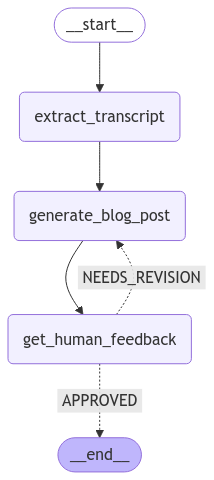

In [71]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
youtube_url="https://www.youtube.com/watch?v=QsYGlZkevEg"

result = graph.invoke({"youtube_url": youtube_url})
print(result)


--- GENERATED BLOG POST ---

### The Heartfelt Journey of Pedro Pascal: From Chile to Hollywood

Pedro Pascal, a name that has become synonymous with some of the most iconic characters in recent television and film, shared an incredibly candid and humorous story that left audiences in stitches and touched hearts. His journey from a freezing Canadian forest to the bright lights of Hollywood is not just a tale of success, but of perseverance, family, and the unexpected twists of fate.

#### The Forest, the Genital Wart, and the Wart Wearing a Mask

Pascal, known for his leading role in "The Last of Us," recounted his latest adventure shooting in a "freezing Canadian forest," all while being chased by a creature whose head looked like a "genital wart." This stark contrast to the five-star Italian resorts of some of his other projects only adds to the charm of his storytelling. The humor in his recount of these experiences is not just a testament to his comedic timing but also a reflectio